In [2]:
from fastai.collab import *


In [3]:
# load in ratings data
ratings = pd.read_csv('ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
#load in book information data
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
# create a collabDataBunch
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')
data.show_batch()

user_id,book_id,target
4068,2690,4.0
22228,9743,2.0
16854,9882,4.0
52895,2401,1.0
11945,489,5.0


In [6]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

# EmbeddingDotBias
there are two type of model for collaborative filtering:
1. EmbeddingDotBias

EmbeddingDotBias(n_factors:int, n_users:int, n_items:int, y_range:Point=None) :: PrePostInitMeta :: Module

2. EmbeddingNN

EmbeddingNN(emb_szs:ListSizes, layers:Collection[int]=None, ps:Collection[float]=None, emb_drop:float=0.0, y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False) :: PrePostInitMeta :: TabularModel

In [11]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


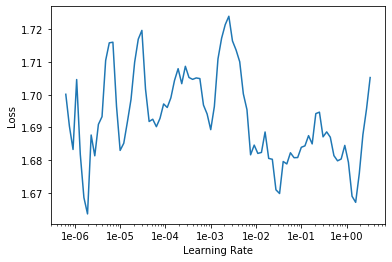

In [12]:
#try fit one cycle method and sace the model
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [13]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,time
0,1.058362,1.059843,08:57
1,0.945989,0.939434,11:38
2,0.878655,0.909242,11:25
3,0.855713,0.870230,10:38
4,0.822981,0.861206,09:59


In [15]:
learn.save('goodbooks-dot-1')

# EmbeddingNN Model
The second type of collaborative filtering model provided by FastAI is called EmbeddingNN. It provides us with the ability to create embeddings with different sizes and feed them into a neural network.
FastAI also provides us with the ability to tweak the number of layers and their units.

In [7]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


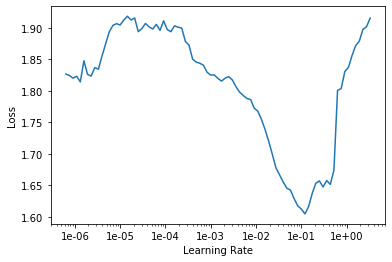

In [8]:
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

In [9]:

learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,time
0,0.791117,0.777399,09:52
1,0.806383,0.765223,12:35
2,0.751034,0.750812,12:22
3,0.727500,0.713266,11:36
4,0.640553,0.708030,10:36


In [10]:
learn.save('goodbooks-nn-1')

# Interpretation
Because the embeddings learned should represent the style and kind of books and users as best as possible they might contain interesting features which we can extract and visualize in order of getting insides.
For this purpose FastAI allows you to easily access both the user and book embeddings as well as their biases.
In this article, we will extract the book biases and weights in order to get insights of what books should be ranked lower or higher, using the embedding bias, as well as how similar some of the most popular books are using the embedding weights.
To start off we will load in our EmbeddingDotBias model and get the 1000 most popular books by how much reviews they have.

In [16]:
# load in EmbeddingDotBias model
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1');

# get top books
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)

# create array containing the names of the top books
top_books_with_name = []
for book in top_books:
    top_books_with_name.append(books[(books['id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)

Now we can extract the biases for the top books as well as the mean rating of the top books and print them out. With this, we can get information about the books that are generally rated low or high no matter what user is rating them.


In [17]:
# get biases for top books
book_bias = learn.bias(top_books, is_item=True)

# get mean ratings
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]

# print book bias information
item0 = lambda o:o[0]
print(sorted(book_ratings, key=item0)[:15])
print(sorted(book_ratings, key=item0, reverse=True)[:15])

# get weights
book_w = learn.weight(top_books, is_item=True)

# transform weights to 3 dimensions
book_pca = book_w.pca(3)

# get prinicipal components
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]

# print fac0 information
print(sorted(book_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(book_comp, key=itemgetter(0))[:10])

# print fac1 information
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]
print(sorted(book_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(book_comp, key=itemgetter(0))[:10])

[(tensor(-0.0197), 'Tweak: Growing Up On Methamphetamines', 3.74), (tensor(-0.0194), 'Rising Sun', 3.36), (tensor(-0.0191), 'A Game of Thrones: The Graphic Novel, Vol. 1', 4.47), (tensor(-0.0189), "The Virgin's Lover (The Plantagenet and Tudor Novels, #13)", 3.55), (tensor(-0.0189), 'Mythology: Timeless Tales of Gods and Heroes', 3.86), (tensor(-0.0187), 'The Stupidest Angel: A Heartwarming Tale of Christmas Terror (Pine Cove, #3)', 3.78), (tensor(-0.0187), 'A Fistful of Charms (The Hollows, #4)', 4.08), (tensor(-0.0187), 'The Arrival', 4.45), (tensor(-0.0185), "The Devil's Arithmetic", 4.08), (tensor(-0.0185), 'Gone for Good', 4.14), (tensor(-0.0183), 'The Collected Poems of W.B. Yeats', 4.08), (tensor(-0.0182), 'The Little Friend', 3.36), (tensor(-0.0180), 'Damned (Damned, #1)', 3.29), (tensor(-0.0180), "Isaac's Storm: A Man, a Time, and the Deadliest Hurricane in History", 3.97), (tensor(-0.0180), 'Bleachers', 3.38)]
[(tensor(0.0197), 'Tricked (The Iron Druid Chronicles, #4)', 4.09)

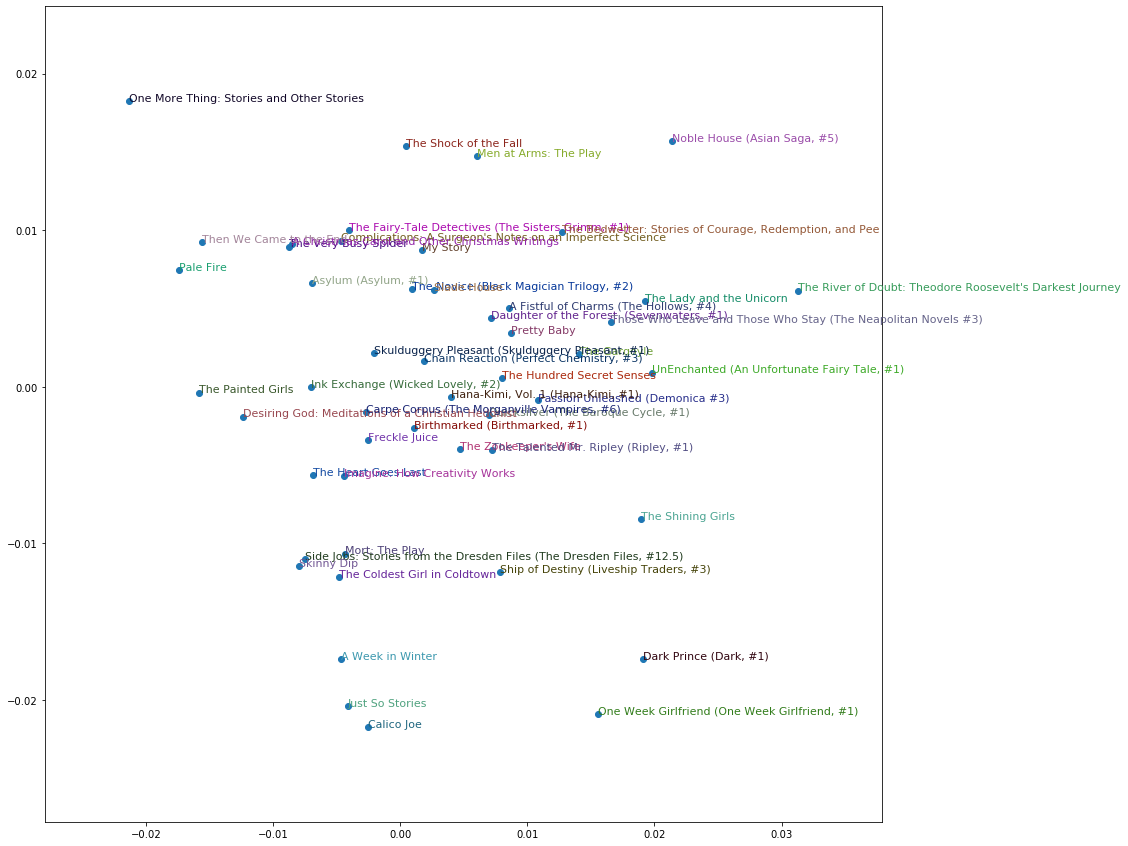

In [19]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()